In [5]:
# import os
# import sys
# import contextlib

# @contextlib.contextmanager
# def suppress_output():
#     with open(os.devnull, 'w') as devnull:
#         old_stdout = sys.stdout
#         old_stderr = sys.stderr
#         sys.stdout = devnull
#         sys.stderr = devnull
#         try:
#             yield
#         finally:
#             sys.stdout = old_stdout
#             sys.stderr = old_stderr

# with suppress_output():
#     import numpy as np
#     import pandas as pd


In [6]:
import numpy as np
import pandas as pd
import torch
device = torch.device("mps")

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
       

# Load the data
pop = pd.read_csv('data/songs_expanded_25_04_01.csv').iloc[:, 2:120]
pop.columns

Index(['song', 'lyrics', 'Segment', 'WC', 'Analytic', 'Clout', 'Authentic',
       'Tone', 'WPS', 'BigWords',
       ...
       'Conversation', 'netspeak', 'assent', 'nonflu', 'filler', 'AllPunc',
       'Period', 'Comma', 'QMark', 'Exclam'],
      dtype='object', length=118)

In [8]:
# processing: currently leaving punctuation alone
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
from gensim.parsing.preprocessing import remove_stopwords
from gensim.utils import simple_preprocess

pop['lyrics'] = pop['lyrics'].astype(str).apply(remove_stopwords)
pop['lyrics-tokenized'] = pop['lyrics'].apply(simple_preprocess)


In [9]:
torch.backends.mps.is_available()
torch.backends.mps.is_built()
device

print(torch.backends.mps.is_available()) 
print(torch.backends.mps.is_built()) 


True
True


In [10]:
import platform
import torch

print("Python:", platform.python_version())
print("macOS:", platform.mac_ver())
print("Machine:", platform.machine())
print("MPS Built:", torch.backends.mps.is_built())
print("MPS Available:", torch.backends.mps.is_available())
print("Torch Version:", torch.__version__)


Python: 3.10.16
macOS: ('10.16', ('', '', ''), 'x86_64')
Machine: x86_64
MPS Built: True
MPS Available: True
Torch Version: 2.2.2


In [11]:
# emotion detection with distilroberta
# https://huggingface.co/j-hartmann/emotion-english-distilroberta-base
# Load model and tokenizer

from transformers import pipeline
emotion_model = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    truncation=True,
    device="mps"
)

# Process the entire column in batch (more efficient than applying row by row)
predictions = emotion_model(pop['lyrics'].tolist(), batch_size=8)

/opt/anaconda3/envs/mps-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use mps


In [12]:
# Extract only the emotion label from each prediction
pop['emotion'] = [pred['label'] for pred in predictions]  # Extract emotion labels
pop['emotion_score'] = [pred['score'] for pred in predictions]  # Extract confidence scores

pop['emotion'].value_counts()

# incorporate emotion columns

# Create columns for each unique emotion with the respective score
emotion_columns = pop['emotion'].unique()  # Get unique emotions

for emotion in emotion_columns:
    pop[emotion] = pop.apply(lambda row: row['emotion_score'] if row['emotion'] == emotion else 0, axis=1)


In [13]:
# add NRC
#https://www.geeksforgeeks.org/emotion-classification-using-nrc-lexicon-in-python/
from nrclex import NRCLex

#google ai popup:
def analyze_emotion(text):
    if isinstance(text, str):
        emotion_lexicon = NRCLex(text)
        return emotion_lexicon.raw_emotion_scores
    else:
        return {} 

#pop = pop.join(pop['emotion_scores'].apply(pd.Series))
pop['emotion_scores_nrc'] = pop['lyrics'].apply(analyze_emotion)

pop['emotion_scores_nrc'].value_counts()

emotion_scores_nrc
{}                                                                                                                                           138
{'negative': 6, 'sadness': 2, 'positive': 4, 'anticipation': 2, 'joy': 2, 'trust': 5, 'anger': 2, 'disgust': 1, 'fear': 3}                     5
{'anger': 3, 'disgust': 1, 'negative': 3, 'fear': 3, 'joy': 3, 'positive': 3, 'sadness': 2}                                                    4
{'fear': 7, 'negative': 7, 'sadness': 5, 'trust': 4, 'anger': 5, 'surprise': 3, 'joy': 6, 'positive': 6, 'disgust': 4, 'anticipation': 3}      4
{'anticipation': 5, 'trust': 4, 'negative': 4, 'sadness': 1, 'fear': 2, 'joy': 3, 'positive': 4, 'surprise': 2, 'disgust': 1}                  3
                                                                                                                                            ... 
{'positive': 3, 'fear': 5, 'negative': 6, 'sadness': 4, 'anger': 4, 'disgust': 3, 'anticipation': 1, 'joy': 1, 

In [14]:
# Total rows
total_rows = pop.shape[0]

# Count of valid dicts
valid_dicts = pop['emotion_scores_nrc'].apply(lambda x: isinstance(x, dict) and len(x) > 0).sum()

# Count of empty dicts
empty_dicts = pop['emotion_scores_nrc'].apply(lambda x: isinstance(x, dict) and len(x) == 0).sum()

# Count of NaNs or None
null_values = pop['emotion_scores_nrc'].isna().sum()

# Summary
print(f"Total rows: {total_rows}")
print(f"Valid emotion dicts: {valid_dicts}")
print(f"Empty emotion dicts: {empty_dicts}")
print(f"Missing (NaN/None): {null_values}")
print(f"Total accounted for: {valid_dicts + empty_dicts + null_values}")


Total rows: 4000
Valid emotion dicts: 3862
Empty emotion dicts: 138
Missing (NaN/None): 0
Total accounted for: 4000


In [15]:
# Convert the dictionary of emotion scores into separate columns
emotion_df = pop['emotion_scores_nrc'].apply(pd.Series)

# Fill missing values (NaNs) with 0 (no emotion detected)
emotion_df = emotion_df.fillna(0)

# Optionally, you can name the columns better by using the emotion names from NRC (if needed)
emotion_df.columns = ['anger_nrc', 'fear_nrc', 'joy_nrc', 'sadness_nrc', 'surprise_nrc', 'disgust_nrc', 'trust_nrc', 'anticipation_nrc', 'negative_nrc', 'positive_nrc']


# Join the emotion_df back to your original pop DataFrame
pop = pop.join(emotion_df)

In [16]:
# now LIWC, NRC, distilbert all together : time for Factor Analysis
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

pop_num = pop.select_dtypes(include='number')

# NEED TO LOOK AT THIS RE  NA VALUES (current dataset has about 220 missing)
pop_num_clean = pop_num.iloc[:,:118].dropna()
print(f"Rows before: {pop_num.shape[0]}, after dropna: {pop_num_clean.shape[0]}")
pop_num_clean = pop_num_clean.loc[:, pop_num_clean.std() != 0]
print((pop_num_clean.std() == 0).sum()) 


chi_square_value,p_value=calculate_bartlett_sphericity(pop_num_clean)
chi_square_value, p_value

# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FactorAnalysis.html
# https://www.datacamp.com/tutorial/introduction-factor-analysis

from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(pop_num_clean)
kmo_model # note this is low



Rows before: 4000, after dropna: 3779
0
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


0.5376328696890549

In [17]:
from factor_analyzer import FactorAnalyzer

# Perform Factor Analysis
fa = FactorAnalyzer(n_factors=2, rotation='varimax')
fa.fit(pop_num_clean)

# Get factor loadings
loadings = fa.loadings_

# Set a threshold for removing low loadings
threshold = 0.3

# Identify columns (items) with low factor loadings
low_loading_items = [pop_num_clean.columns[i] for i in range(loadings.shape[0]) if any(abs(loadings[i, :]) < threshold)]

print(f"Items with low factor loadings (below {threshold}):")
print(low_loading_items)

# Remove those items from the original DataFrame
pop_num_concise = pop_num_clean.drop(columns=low_loading_items)

# Check the cleaned dataset
print(f"DataFrame after removing low loading items: {pop_num_concise.shape}")

print(f"Remaining columns after removing low loading items: {pop_num_concise.columns.tolist()}")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [18]:
# redo our calculations:

chi_square_value,p_value=calculate_bartlett_sphericity(pop_num_concise)
chi_square_value, p_value

# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FactorAnalysis.html
# https://www.datacamp.com/tutorial/introduction-factor-analysis

from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(pop_num_concise)
kmo_model # note this is 'Meritorious' (~0.82)
# https://bookdown.org/luguben/EFA_in_R/kaiser-meyer-olkin-kmo.html

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


0.8223379057943897

In [19]:
# Perform Factor Analysis
fa = FactorAnalyzer(n_factors=2, rotation='varimax')
fa.fit(pop_num_concise)

# Get factor loadings
loadings = fa.loadings_

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [20]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer()
fa = FactorAnalyzer(n_factors=2, rotation="varimax")
fa.fit(pop_num_clean)

fa.get_factor_variance()

# Get factor variance breakdown
variance, proportion_variance, cumulative_variance = fa.get_factor_variance()

# Print cumulative variance explained by all factors
print("Cumulative variance (proportion):", cumulative_variance)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


[            Factor 1  Factor 2
function    0.776244  0.214870
Cognition   0.752730  0.276421
cogproc     0.731404  0.300838
Linguistic  0.723465  0.327377
verb        0.672947  0.278218
auxverb     0.649831  0.191810,               Factor 1  Factor 2
female       -0.332780  0.197331
Conversation -0.362147  0.255013
WC           -0.392118 -0.041234
Comma        -0.429280  0.138808
swear        -0.476262 -0.099636
Analytic     -0.652369 -0.538321]


<Figure size 1000x600 with 0 Axes>

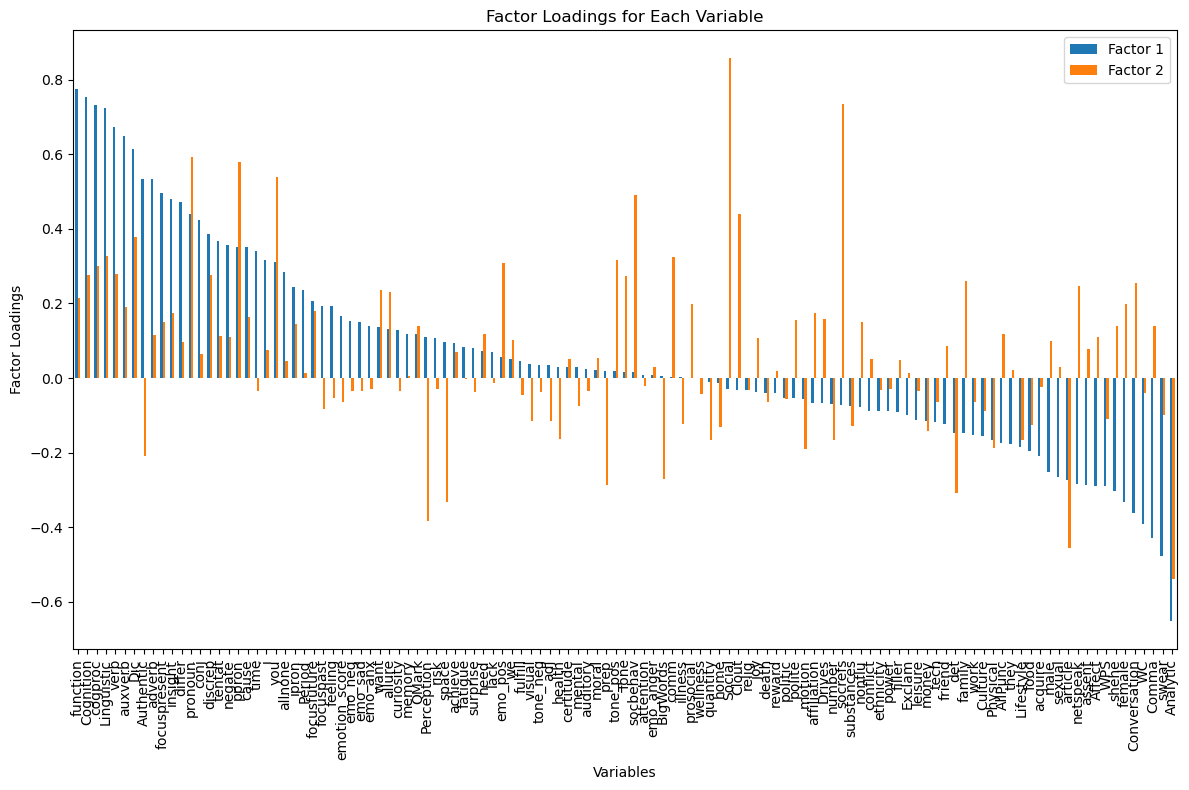

In [21]:
import seaborn as sns

loadings = fa.loadings_

# Create a DataFrame for factor loadings for easier visualization
loadings_df = pd.DataFrame(loadings, columns=[f'Factor {i+1}' for i in range(loadings.shape[1])], index=pop_num_clean.columns)
sorted_loadings_df = loadings_df.sort_values(by='Factor 1', ascending=False)


# Print factor loadings for each variable
print([sorted_loadings_df.head(6), sorted_loadings_df.tail(6)])

# Plot bar chart of loadings for each variable in each factor
plt.figure(figsize=(10, 6))
# Set the axis limits for zooming in
sorted_loadings_df.plot(kind='bar', figsize=(12, 8))
plt.title("Factor Loadings for Each Variable")
plt.xlabel("Variables")
plt.ylabel("Factor Loadings")
plt.xticks(rotation=90)  # Rotate variable names for readability
plt.tight_layout()
plt.show()




In [22]:
# tidy up the factor analysis: 
keepers = ["function", "Cognition", "cogproc", "Linguistic", "WC","Comma", "swear","Analytic",
"Social", "socrefs", "pronoun", "ppron", "space", "Perception", "article"]
pop_num_f = pop_num[keepers].dropna()



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


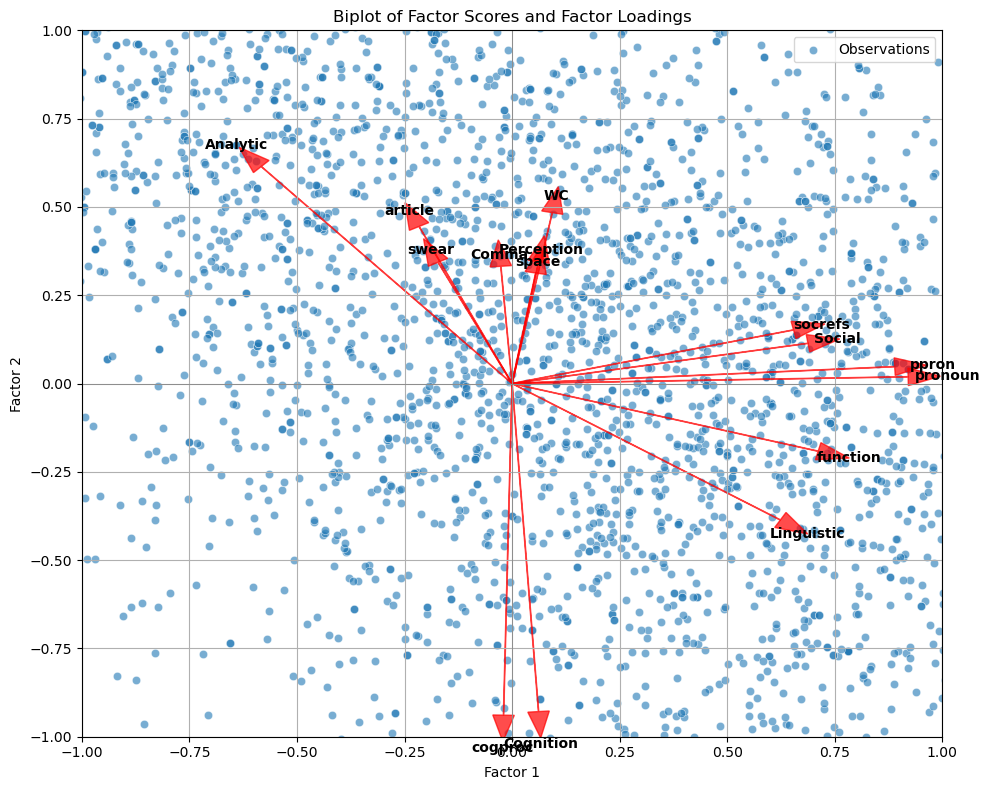

In [23]:
# biplot
import matplotlib.pyplot as plt

# Assuming 'pop_num_clean' is your cleaned DataFrame
fa = FactorAnalyzer(n_factors=2, rotation='varimax')
fa.fit(pop_num_f)

fa.get_factor_variance()

# Get factor variance breakdown
variance, proportion_variance, cumulative_variance = fa.get_factor_variance()

# Print cumulative variance explained by all factors
print("Cumulative variance (proportion):", cumulative_variance)

# Get the factor loadings (matrix)
loadings = fa.loadings_

# Get the factor scores (coordinates of observations in factor space)
factor_scores = fa.transform(pop_num_f)

# Create a DataFrame for factor loadings for easier visualization
loadings_df = pd.DataFrame(loadings, columns=[f'Factor {i+1}' for i in range(loadings.shape[1])], index=pop_num_f.columns)

# Create a biplot: Factor scores (observations) and factor loadings (variables)
plt.figure(figsize=(10, 8))

# Plot factor scores
sns.scatterplot(x=factor_scores[:, 0], y=factor_scores[:, 1], alpha=0.6, label='Observations')

# Plot factor loadings (arrows for variables)
for i, var in enumerate(loadings_df.index):
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], color='red', alpha=0.7, head_width=0.05)
    plt.text(loadings[i, 0] * 1.1, loadings[i, 1] * 1.1, var, color='black', ha='center', va='center', fontweight='bold')

# Labels and title
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
# Set the axis limits for zooming in
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title('Biplot of Factor Scores and Factor Loadings')
plt.axhline(0, color='gray',linewidth=0.5)
plt.axvline(0, color='gray',linewidth=0.5)
plt.grid(True)
plt.tight_layout()
plt.show()


In [24]:
## UMAP
factor_scores = fa.transform(pop_num_f)

import umap
import matplotlib.pyplot as plt

# Initialize UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=13)

# Fit and transform the factor scores
umap_embedding = reducer.fit_transform(factor_scores)




Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/opt/anaconda3/envs/mps-env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertias = []
k_range = range(1, 3)  # Try 1 to 10 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=13)
    kmeans.fit(factor_scores)
    inertias.append(kmeans.inertia_)

# Plot the scree (elbow) plot
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()

/opt/anaconda3/envs/mps-env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
import seaborn as sns

# For example, add clustering:

clusters = KMeans(n_clusters=4, random_state=13).fit_predict(factor_scores)

# Visualize with colors
sns.scatterplot(x=umap_embedding[:, 0], y=umap_embedding[:, 1], hue=clusters, palette="viridis", s=30)
plt.title("UMAP of Factor Scores with Clusters")
plt.show()

/opt/anaconda3/envs/mps-env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
pop_clusters = pop[pop[keepers].notna().all(axis=1)].copy()
pop_clusters['cluster'] = clusters

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train = df_with_clusters[feature_columns]  # e.g., original features
y_train = df_with_clusters['cluster']



X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_tr, y_tr)

y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))